In [1]:
# Libraries ----
import os
import re
import sys
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append("../modules")
import plot_hoi as ph  # type: ignore
import plot_complexity as pc  # type: ignore
import plot_interactive as pi  # type: ignore
import plot_synchronization as ps  # type: ignore
import estimate_hoi_measures as ehm  # type: ignore
import estimate_complexity_measures as ecm  # type: ignore
import plot_complex_network_analysis as pcna  # type: ignore
import estimate_synchronization_analysis as esa  # type: ignore
import estimate_complex_network_analysis as ecna  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)

## Global variables

In [2]:
log_path = "../logs"
input_path = "../input_files"
output_path = "../output_files"
input_generation_date = "2025-02-18"
x_bounds = [0, 1920]
y_bounds = [0, 1080]
t_threshold = 3600

## Load and prepare data of all tracked videos

In [3]:
cols = [
    "particles",
    "video",
    "permuted_id",
    "time",
    "position_x",
    "position_y",
    "corrected_orientation",
    "n_x",
    "n_y",
    "n_orientation",
    "norm"
]

df_final = []
for file in os.listdir(input_path):
    df = pd.read_csv(input_path + "/" + file, low_memory=False)
    df["video"] = re.sub("reviewed_", "", re.sub(".csv", "", file))
    df["particles"] = df["video"].str[0]
    df["n_x"] = df["position_x"] / x_bounds[1] - 0.5  # Normalized position in X-axis
    df["n_y"] = df["position_y"] / y_bounds[1] - 0.5  # Normalized position in Y-axis
    df["n_orientation"] = np.sin(df["corrected_orientation"])  # Normalized Orientation
    df["norm"] = (
        np.power(df["n_x"], 2)
        + np.power(df["n_y"], 2)
        + np.power(df["n_orientation"], 2)
    )
    df_final.append(df[df["time"] <= t_threshold][cols])

df_final = pd.concat(df_final, ignore_index=True)
df_final

particles              video  permuted_id  time   position_x  \
0             2  2n_0m_2f_230330_1            0     0  1657.350058   
1             2  2n_0m_2f_230330_1            1     0  1221.582078   
2             2  2n_0m_2f_230330_1            0     3  1675.103082   
3             2  2n_0m_2f_230330_1            1     3  1221.530021   
4             2  2n_0m_2f_230330_1            0     6  1675.049035   
...         ...                ...          ...   ...          ...   
54040         4  4n_4m_0f_230523_2            3  3597   411.256103   
54041         4  4n_4m_0f_230523_2            0  3600   244.905086   
54042         4  4n_4m_0f_230523_2            1  3600   315.592605   
54043         4  4n_4m_0f_230523_2            2  3600   923.548563   
54044         4  4n_4m_0f_230523_2            3  3600   412.479307   

       position_y  corrected_orientation       n_x       n_y  n_orientation  \
0       59.069803               1.473471  0.363203 -0.445306       0.995268   
1       92.427967              -1.507389  0.136241 -0.414419      -0.997990   
2       58.309940               1.546517  0.372450 -0.446009       0.999705   
3       92.132771              -1.512559  0.136214 -0.414692      -0.998305   
4       58.351203               1.544728  0.372421 -0.445971       0.999660   
...           ...                    ...       ...       ...            ...   
54040  541.839636              -0.028980 -0.285804  0.001703      -0.028976   
54041  574.666178               3.103433 -0.372445  0.032098       0.038151   
54042  783.672704               2.764931 -0.335629  0.225623       0.367818   
54043  321.790707               0.997767 -0.018985 -0.202046       0.840262   
54044  537.647846               0.062069 -0.285167 -0.002178       0.062030   

           norm  
0      1.320771  
1      1.186289  
2      1.337054  
3      1.187136  
4      1.336909  
...         ...  
54040  0.082527  
54041  0.141201  
54042  0.298842  
54043  0.747223  
54044  0.085173  

[54045 rows x 11 columns]

## Plot time series of each individual

In [4]:
pi.interactive_plot(df=df_final, interval_size=600)

# Are there higher-order interactions in 3 and 4 cockroach videos?

- Aim: To classify regimes as redundancy-dominated or synergy-dominated over time.
- Data: Distances from the center of the box and orientation of the cockroaches respect to the vertical.

## Get O-information data between individuals
O-Information is a measure used in information theory to quantify **high-order interactions** in multivariate systems. It distinguishes between redundant and synergistic information sharing across multiple variables.

### **Mathematical Formulation**

For a set of random variables $(X_1, X_2, ..., X_N)$, the O-Information and exogenous information are defined as:

\begin{align}
    \Omega(X_1, X_2, ..., X_N) &= TC(\mathbf{X}_{n}) - DTC(\mathbf{X}_{n}) = \sum_{i=1}^{N} I(X_i; \mathbf{X}_{-i}) - I(\mathbf{X}_1, ..., \mathbf{X}_N) \\
    S(X_1, X_2, ..., X_N) &= TC(\mathbf{X}_{n}) + DTC(\mathbf{X}_{n})
\end{align}

respectively, where:

- $I(X_i; \mathbf{X}_{-i})$ is the mutual information between $X_i$ and the rest.
- $I(\mathbf{X}_1, ..., \mathbf{X}_N)$ is the total multivariate mutual information.
- If $\Omega>0$, the system is redundancy-dominated.
- If $\Omega<0$, the system is synergy-dominated.


In [5]:
window_sizes = [
    [30], [36], [45], [48], [60], [72], [75], [90],
    [120], [144], [150], [180], [225],
    [240], [300], [360], [450], [600],
    [720], [900], [1200], [1800], [t_threshold]
]
df_oinfo = []
for video in df_final["video"].unique():
    df = df_final[df_final["video"] == video]
    if int(video[0]) >= 3:
        df_aux = ehm.estimate_oinfo_multiple_windows(
            df=df,
            window_sizes=window_sizes,
            log_path=log_path,
            log_filename="log_hoi",
            verbose=1,
            tqdm_bar=True
        )
        df_oinfo.append(df_aux)

df_oinfo = pd.concat(df_oinfo, ignore_index=True)
df_oinfo.to_csv(output_path + "/df_hoi.csv", index=False)
df_oinfo

100%|███████████████████████| 23/23 [07:12<00:00, 18.82s/it]


video    t_range  size multiplet  oinfo_distance  \
0     3n_0m_3f_230404_1     0 - 30    30       012       -0.035616   
1     3n_0m_3f_230404_1    30 - 60    30       012             NaN   
2     3n_0m_3f_230404_1    60 - 90    30       012       -0.667958   
3     3n_0m_3f_230404_1   90 - 120    30       012        0.539916   
4     3n_0m_3f_230404_1  120 - 150    30       012        0.482395   
...                 ...        ...   ...       ...             ...   
9043  4n_4m_0f_230523_2   0 - 3600  3600       012        0.017668   
9044  4n_4m_0f_230523_2   0 - 3600  3600       013       -0.052032   
9045  4n_4m_0f_230523_2   0 - 3600  3600       023        0.053678   
9046  4n_4m_0f_230523_2   0 - 3600  3600       123       -0.009590   
9047  4n_4m_0f_230523_2   0 - 3600  3600      0123        0.017460   

      oinfo_orientation  sinfo_distance  sinfo_orientation  
0              0.028209        0.404459           0.170158  
1              0.187642             NaN           2.382899  
2              0.100093        6.671617           0.780154  
3             -0.054813        3.652570           0.305895  
4              0.066044        2.131849          -0.021222  
...                 ...             ...                ...  
9043          -0.012133        0.338304           0.355206  
9044          -0.001674        0.696107           0.426130  
9045          -0.012717        0.589312           0.289693  
9046           0.009411        0.215366           0.498178  
9047           0.007252        0.889482           0.761539  

[9048 rows x 8 columns]

In [6]:
for video in df_oinfo["video"].unique():
    fig_oinfo, ax_oinfo = ph.plot_gliding_oinfo(
        df_oinfo=df_oinfo[df_oinfo["video"] == video],
        width=16,
        height=5,
        n_x_breaks=20,
        n_y_breaks=20,
        fancy_legend=True,
        save_figure=True,
        output_path=output_path,
        output_name="plot_gliding_oinfo_" + video
    )

Figure saved to ../output_files\plot_gliding_oinfo_3n_0m_3f_230404_1.png
Figure saved to ../output_files\plot_gliding_oinfo_3n_0m_3f_230404_2.png
Figure saved to ../output_files\plot_gliding_oinfo_3n_0m_3f_240215_1.png
Figure saved to ../output_files\plot_gliding_oinfo_3n_1m_2f_240213_1.png
Figure saved to ../output_files\plot_gliding_oinfo_3n_1m_2f_240215_1.png
Figure saved to ../output_files\plot_gliding_oinfo_3n_1m_2f_240216_1.png
Figure saved to ../output_files\plot_gliding_oinfo_3n_1m_2f_240216_2.png
Figure saved to ../output_files\plot_gliding_oinfo_4n_4m_0f_230523_2.png


In [7]:
df_oinfo_summary, fig_oinfo_1, fig_oinfo_2, ax_oinfo_1, ax_oinfo_2 = ph.plot_hoi_metrics_summary(
    df_oinfo=df_oinfo,
    width=16,
    height=8,
    n_x_breaks=20,
    n_y_breaks=20,
    fancy_legend=True,
    save_figures=True,
    output_path=output_path,
    output_name="plot_gliding_oinfo_summary"
)

Figure saved to ../output_files\plot_gliding_oinfo_summary_video.png and ../output_files\plot_gliding_oinfo_summary_sexratio.png


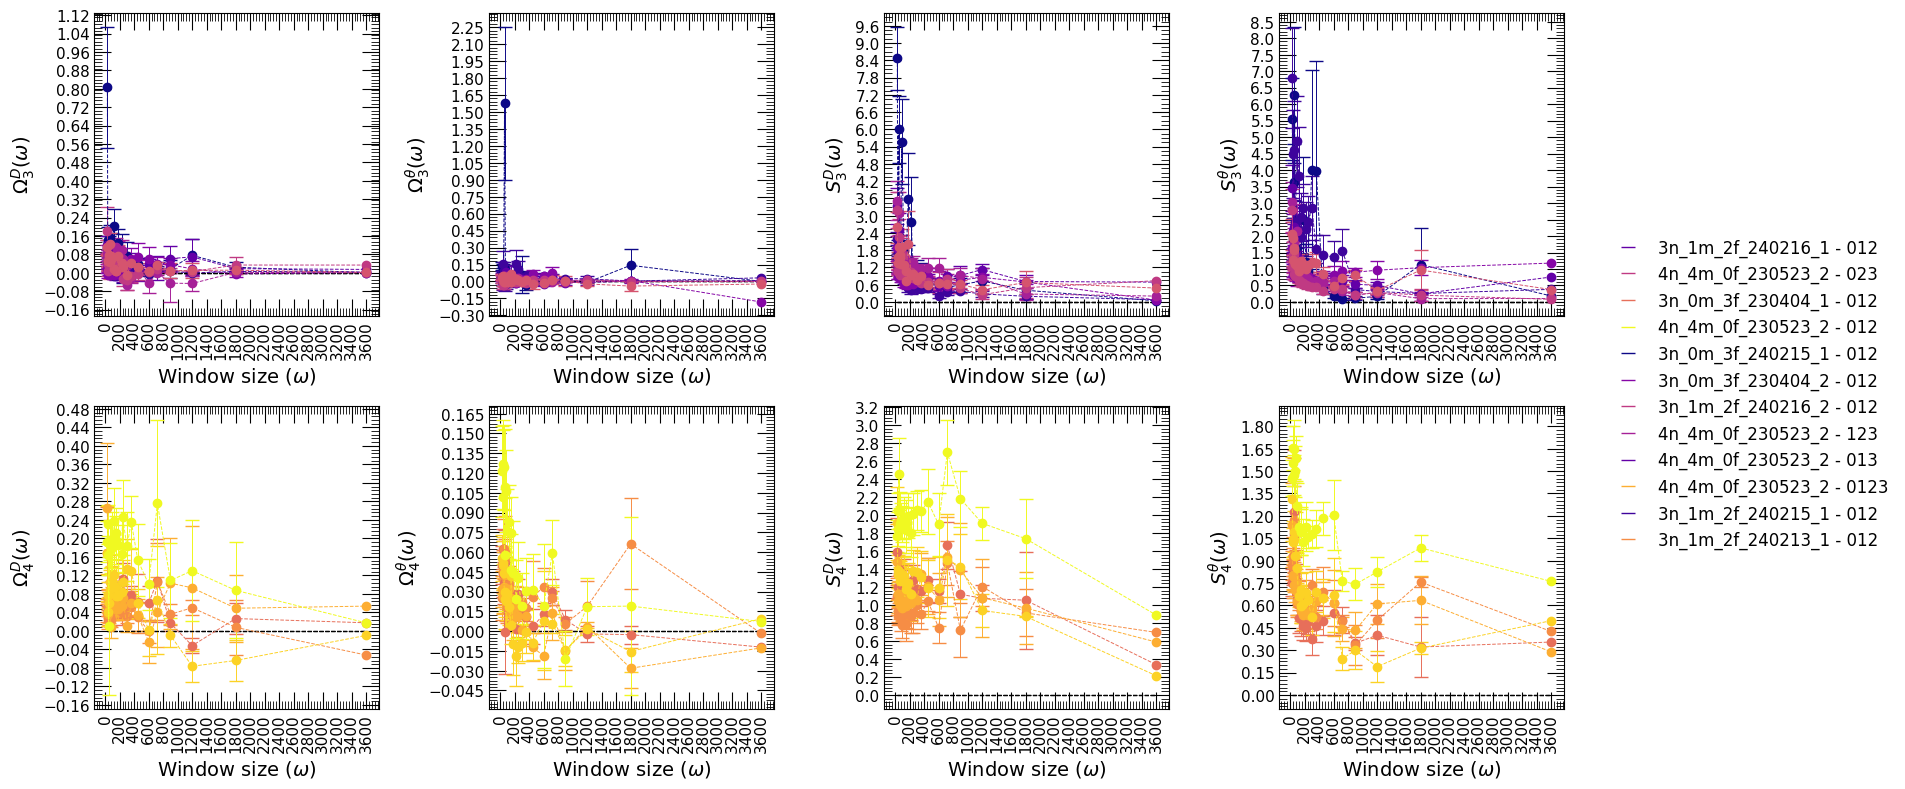

In [8]:
fig_oinfo_1

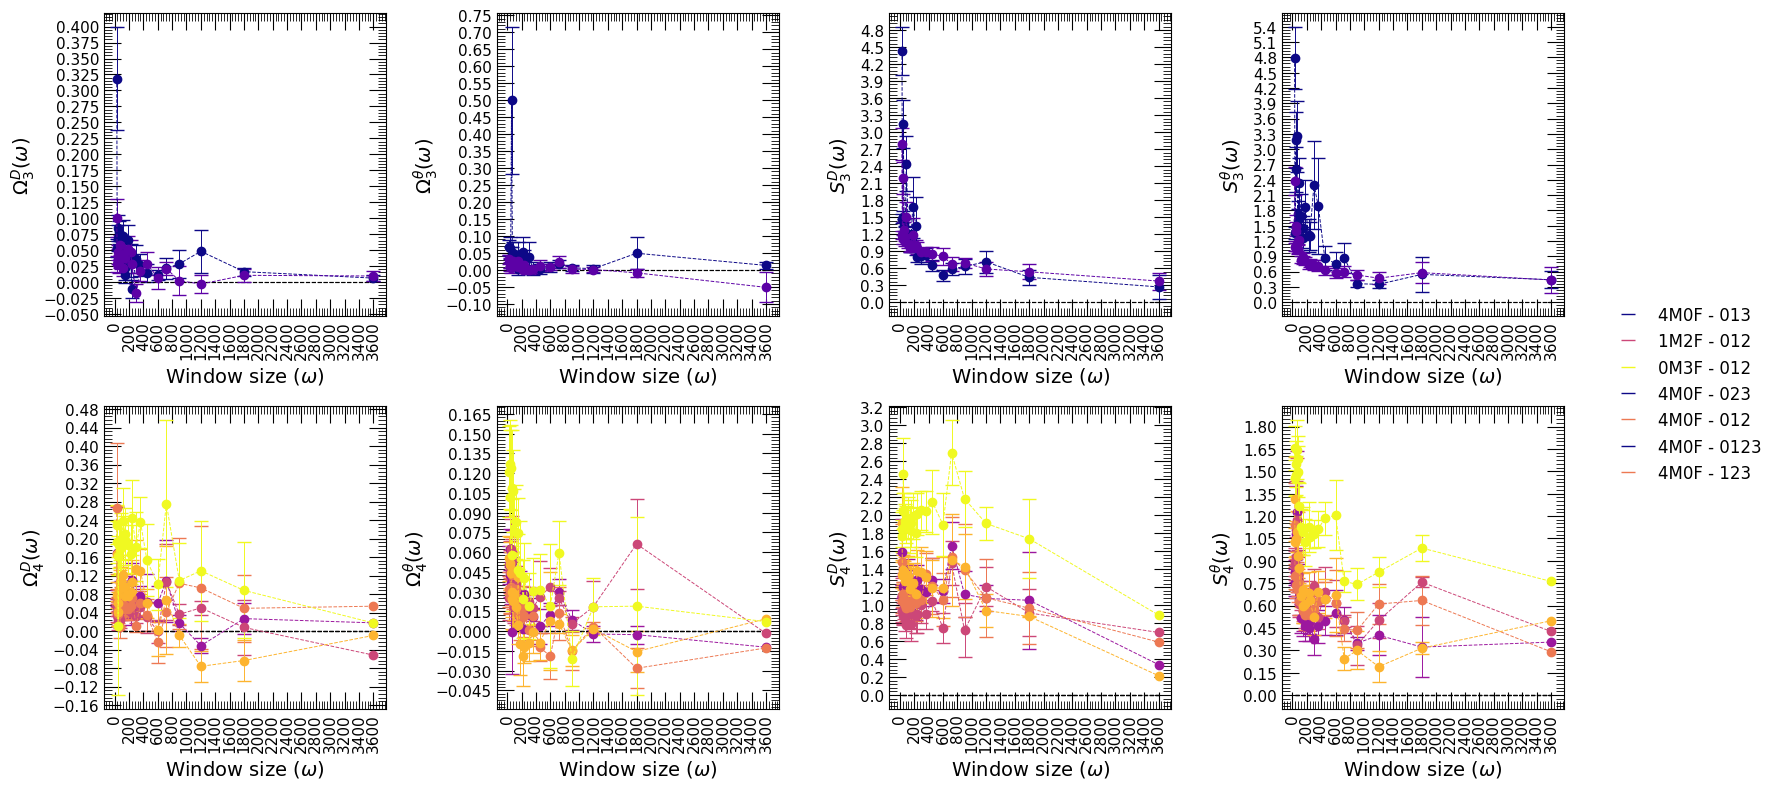

In [9]:
fig_oinfo_2

---
# How different is the behavior when sex ratio changes (fixed group size)?

- Aim: To estimate Hurst exponent (asses persistence), Permutation entropy (predictability), Statistical complexity (assess the balance of order and randomness) for each cockroach’s time series (distance, orientation) → persistence vs. randomness.
- Data: Distances from the center of the box and orientation of the cockroaches respect to the vertical.
---

## Get Hurst exponent, permutation entropy and Statistical complexity data between individuals

### **Mathematical Formulation**

#### 1. Hurst Exponent

The Hurst exponent ($H$) is a statistical measure used to evaluate the long-term memory of time series data. It quantifies the tendency of a time series to either:

- Persist in its trend ($H > 0.5$)
- Exhibit a random walk ($H ≈ 0.5$)
- Mean-revert (antipersistence) ($H < 0.5$)

The Hurst exponent is estimated using the rescaled range (R/S) analysis:

\begin{equation}
    H = \lim_{T \to \infty} \frac{\log(R/S)}{\log(T)},
\end{equation}

where $R$ is the range of cumulative deviations from the mean, $S$ is the standard deviation, and $T$ is the time window size.

Also, Multifractal Detrended Fluctuation Analysis (MF-DFA) is an extension of DFA (Detrended Fluctuation Analysis) that measures the **multifractal properties** of a time series by analyzing its scaling behavior at different moments $q$. The fluctuation function is defined as:

\begin{equation}
    F_q(s) = \left( \frac{1}{N_s} \sum_{\nu=1}^{N_s} F^q(\nu, s) \right)^{\frac{1}{q}}
\end{equation}

where $F(\nu, s)$ is the local detrended fluctuation at segment $\nu$, and $s$ is the window size.

#### 2. Permutation Entropy

Permutation Entropy ($PE$) is a nonlinear measure of time series complexity introduced by Bandt & Pompe (2002). It quantifies the randomness in a time series by analyzing the frequency of ordinal patterns of a given length.

Given a time series $X = \{x_1, x_2, ..., x_N\}$ and an embedding dimension $d$, we extract ordinal patterns by ranking the values within sliding windows of size $\tau$. The permutation entropy is then computed as:

\begin{equation}
    H_p = - \sum p(\pi) \log p(\pi)
\end{equation}

where $p(\pi)$ is the probability of each ordinal pattern $\pi$.

#### 3. Statistical complexity

Statistical complexity measures the balance between disorder and structure in a system. It complements entropy by identifying structured patterns within randomness.

A widely used definition is the **Jensen-Shannon complexity**, which combines permutation entropy and disequilibrium:

\begin{equation}
    C_J = H_p \cdot Q_J
\end{equation}

where $Q_J$ is the Jensen-Shannon divergence measuring disequilibrium.

---
## **References**

- Bandt, C., & Pompe, B. (2002). Permutation entropy: A natural complexity measure for time series.
- Rosso, O. A., et al. (2007). Distinguishing noise from chaos.
- Ribeiro, H. V., et al. (2012). Characterizing time series through complexity-entropy curves.
- `ordpy`: A Python library for ordinal pattern analysis.
---

In [10]:
window_sizes = [
    # [30], [36], [45], [48], [60], [72], [75], [90],
    [120], [144], [150], [180], [225], [240],
    [300], [360], [450], [600],
    [720], [900], [1200], [1800], [t_threshold]
]
df_complexity = []
for video in df_final["video"].unique():
    df = df_final[df_final["video"] == video]
    df_aux = ecm.estimate_multiple_hurst_complexity(
        df=df,
        window_sizes=window_sizes,
        q=2,
        dx=3,
        taux=1,
        log_path=log_path,
        log_filename="log_complexity",
        verbose=1,
        tqdm_bar=True
    )

    df_complexity.append(df_aux)

df_complexity = pd.concat(df_complexity, ignore_index=True)
df_complexity.to_csv(output_path + "/df_complexity.csv", index=False)
df_complexity

100%|███████████████████████| 15/15 [00:08<00:00,  1.72it/s]


video      t_range  size  permuted_id  H_distance  \
0     2n_0m_2f_230330_1      0 - 120   120            0    0.953073   
1     2n_0m_2f_230330_1      0 - 120   120            1    1.080869   
2     2n_0m_2f_230330_1    120 - 240   120            0    0.815270   
3     2n_0m_2f_230330_1    120 - 240   120            1    1.081105   
4     2n_0m_2f_230330_1    240 - 360   120            0    0.880101   
...                 ...          ...   ...          ...         ...   
8140  4n_4m_0f_230523_2  1800 - 3600  1800            3    0.214942   
8141  4n_4m_0f_230523_2     0 - 3600  3600            0    0.362870   
8142  4n_4m_0f_230523_2     0 - 3600  3600            1    0.778787   
8143  4n_4m_0f_230523_2     0 - 3600  3600            2    0.733202   
8144  4n_4m_0f_230523_2     0 - 3600  3600            3    0.407086   

      PE_distance  C_distance  H_orientation  PE_orientation  C_orientation  
0        0.965997    0.033541       0.505706        0.943277       0.052641  
1        0.945674    0.050441       0.980146        0.964793       0.033099  
2        0.966759    0.032270       0.342645        0.968650       0.029637  
3        0.925676    0.070451       0.523228        0.965623       0.031898  
4        0.956619    0.039457       0.365565        0.964778       0.031184  
...           ...         ...            ...             ...            ...  
8140     0.951226    0.044847       0.343959        0.945015       0.049889  
8141     0.955779    0.040500       0.232728        0.956867       0.039692  
8142     0.880230    0.102135       0.281743        0.913399       0.076053  
8143     0.903201    0.084074       0.400831        0.908576       0.079667  
8144     0.938125    0.055203       0.407935        0.938068       0.055864  

[8145 rows x 10 columns]

In [11]:
for video in df_complexity["video"].unique():
    fig_complexity, ax_complexity = pc.plot_gliding_complexity(
        df_complexity=df_complexity[df_complexity["video"] == video],
        width=16,
        height=8,
        n_x_breaks=20,
        n_y_breaks=20,
        fancy_legend=True,
        save_figure=True,
        output_path=output_path,
        output_name="plot_gliding_complexity_" + video
    )

Figure saved to ../output_files\plot_gliding_complexity_2n_0m_2f_230330_1.png
Figure saved to ../output_files\plot_gliding_complexity_2n_0m_2f_230404_1.png
Figure saved to ../output_files\plot_gliding_complexity_2n_0m_2f_230522_2.png
Figure saved to ../output_files\plot_gliding_complexity_2n_0m_2f_230522_3.png
Figure saved to ../output_files\plot_gliding_complexity_2n_0m_2f_230523_1.png
Figure saved to ../output_files\plot_gliding_complexity_2n_1m_1f_230522_1.png
Figure saved to ../output_files\plot_gliding_complexity_2n_1m_1f_240215_1.png
Figure saved to ../output_files\plot_gliding_complexity_2n_1m_1f_240219_1.png
Figure saved to ../output_files\plot_gliding_complexity_2n_1m_1f_240219_2.png
Figure saved to ../output_files\plot_gliding_complexity_2n_1m_1f_240226_1.png
Figure saved to ../output_files\plot_gliding_complexity_3n_0m_3f_230404_1.png
Figure saved to ../output_files\plot_gliding_complexity_3n_0m_3f_230404_2.png
Figure saved to ../output_files\plot_gliding_complexity_3n_0m_3f

In [12]:
df_complexity_summary, fig_complexity_1, fig_complexity_2, ax_complexity_1, ax_complexity_2 = pc.plot_complexity_metrics_summary(
    df_complexity=df_complexity,
    width=24,
    height=12,
    n_x_breaks=20,
    n_y_breaks=20,
    fancy_legend=True,
    save_figures=True,
    output_path=output_path,
    output_name="plot_gliding_complexity_summary"
)

Figure saved to ../output_files\plot_gliding_complexity_summary_video.png and ../output_files\plot_gliding_complexity_summary_sexratio.png


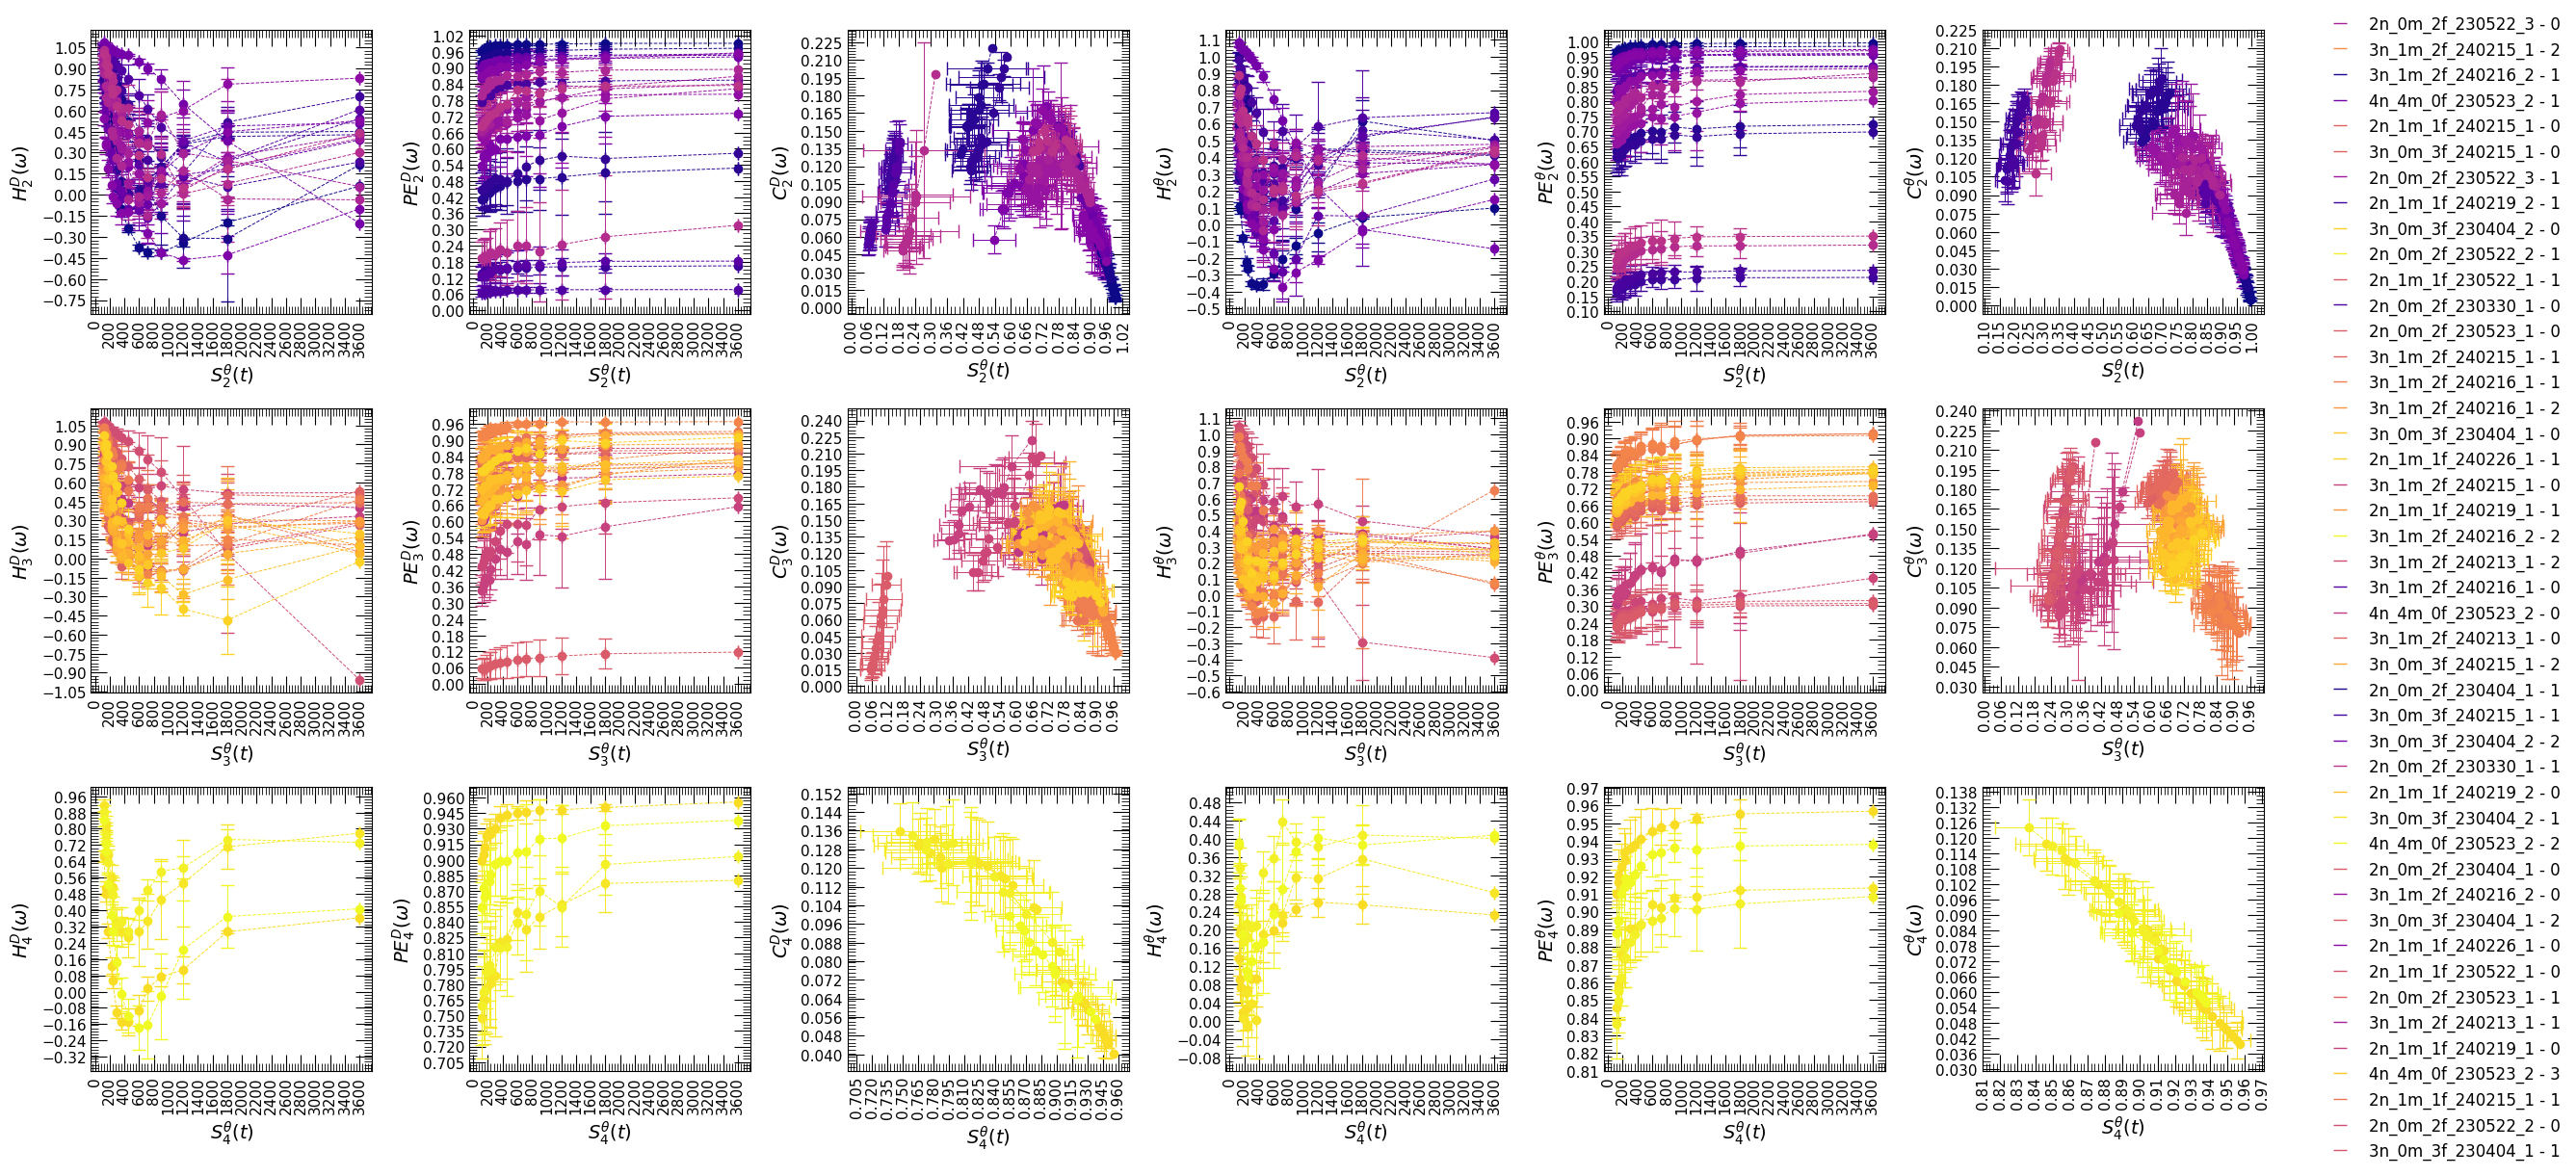

In [13]:
fig_complexity_1

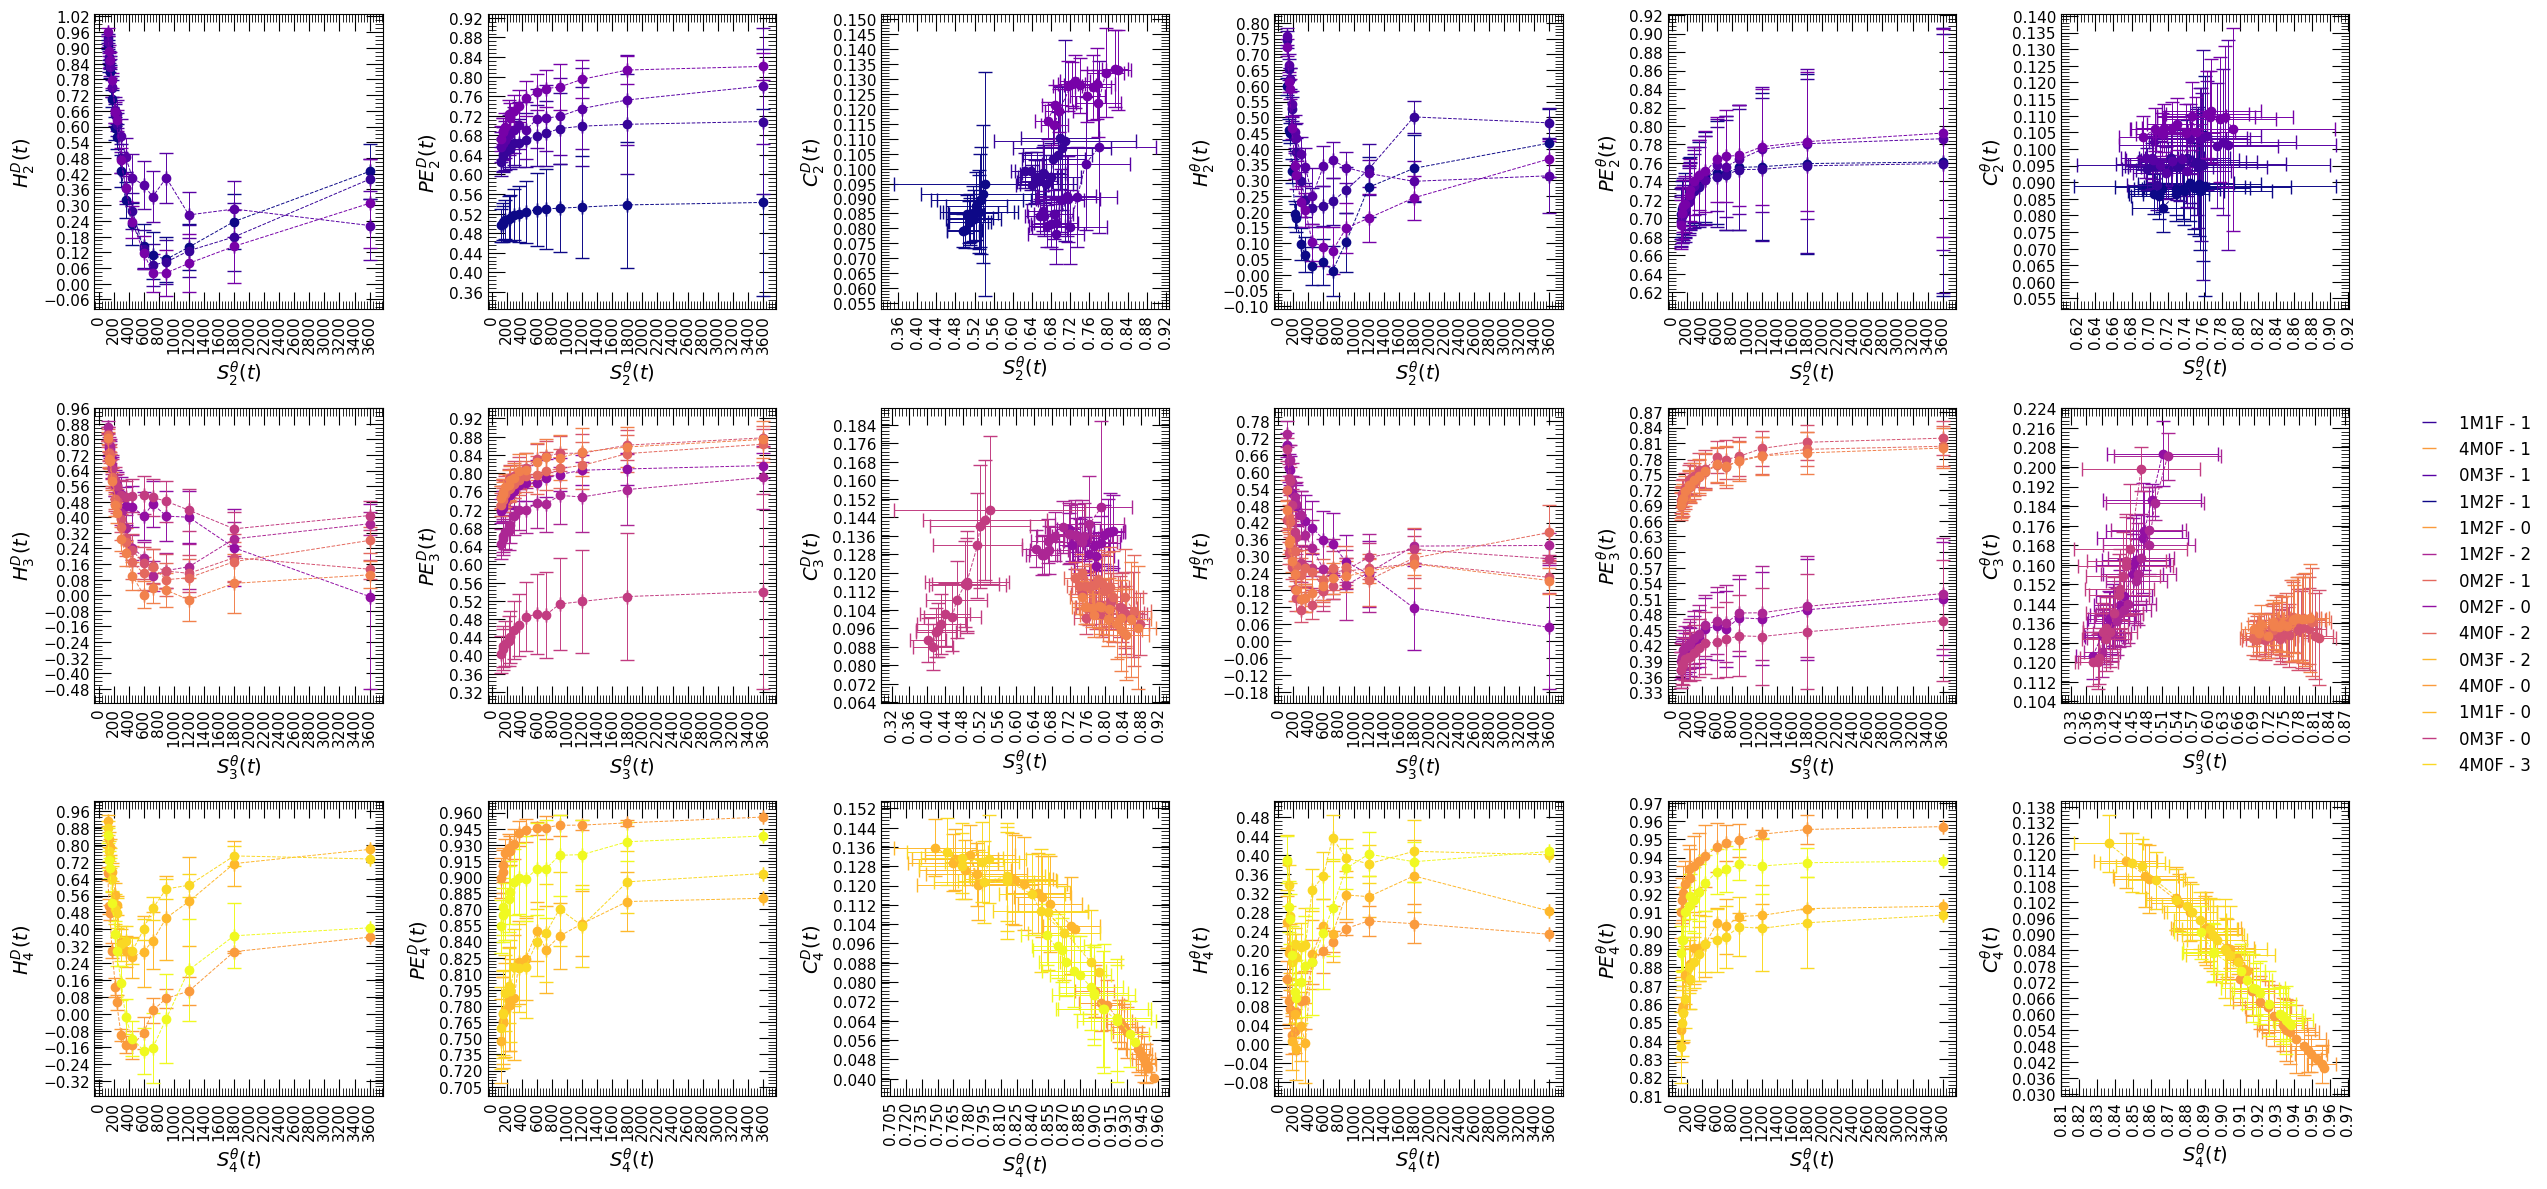

In [14]:
fig_complexity_2

---
# How different is the behavior when sex ratio changes (fixed group size)?

- Aim: To examine coordination and coupling using Cross-recurrence quantification analysis (CRQA).
- Data: Distances from the center of the box and orientation of the cockroaches respect to the vertical.
---

## Synchronization in Complex Systems

### **Mathematical Formulation**

#### 1. Recurrence Plot Analysis (RPA)

**Recurrence Plot Analysis (RPA)** is a nonlinear method for studying the dynamics and synchronization of complex systems. It visualizes when a system revisits the same or similar state in its phase space.

Given a trajectory $\vec{x}_i \in \mathbb{R}^d$, the **recurrence matrix** is defined as:

\begin{equation}
    R_{i,j} = \Theta(\varepsilon - \|\vec{x}_i - \vec{x}_j\|),
\end{equation}

where:
- $\varepsilon$ is a threshold,
- $\Theta$ is the Heaviside step function,
- $R_{i,j} = 1$ means state $i$ recurs at time $j$.

The resulting binary matrix can be visualized as a **recurrence plot**.

**Recurrence Quantification Analysis (RQA)** converts the visual features of recurrence plots into quantitative metrics:

| Metric | Description |
|--------|-------------|
| **RR** – Recurrence Rate | Ratio of recurrent points in the plot |
| **DET** – Determinism | Fraction of recurrent points forming diagonal lines (indicating predictability) |
| **L** – Average Diagonal Line Length | Mean time over which the system exhibits similar behavior |
| **ENTR** – Entropy | Shannon entropy of diagonal line lengths (complexity measure) |
| **LAM** – Laminarity | Fraction of points forming vertical lines (indicating intermittency or stationarity) |
| **TT** – Trapping Time | Average vertical line length |

These metrics help detect patterns such as synchronization, chaos, and transitions in dynamics.

---

#### 2. Kuramoto Model & Synchronization

The **Kuramoto model** is a classical model for understanding synchronization in populations of coupled oscillators (e.g., neurons, fireflies, mechanical rotors).

Each oscillator $i$ has a phase $\theta_i(t)$, and their interaction is governed by:

\begin{equation}
    \frac{d\theta_i}{dt} = \omega_i + \frac{K}{N} \sum_{j=1}^{N} \sin(\theta_j - \theta_i),
\end{equation}

where:
- $\omega_i$ is the natural frequency,
- $K$ is the coupling strength,
- $N$ is the number of oscillators.

The **degree of synchronization** is measured by the **Kuramoto order parameter** $R(t)$:

\begin{equation}
    R(t) = \left| \frac{1}{N} \sum_{j=1}^{N} e^{i \theta_j(t)} \right|
\end{equation}

- $R(t) \in [0, 1]$
- $R(t) \approx 1$: perfect phase synchronization
- $R(t) \approx 0$: desynchronized or incoherent state

This metric summarizes global coherence in the system and is often visualized as a function of time or coupling strength $K$.

The **Kuramoto parameter** offers a global phase measure, while **RQA** captures finer nonlinear structures and local synchrony.

---

In [15]:
Rs, df_metrics = esa.estimate_multiple_crqa(
    df=df_final,
    epsilon_factor=0.05,
    plot=False,
    min_diagonal_length=2,
    min_vertical_length=2
)
df_metrics.to_csv(output_path + "/df_recurrence.csv", index=False)
df_metrics

video id_pair        RR       DET          L      ENTR  \
0   2n_0m_2f_230330_1      00  0.056358  0.312642   2.378123  0.650011   
1   2n_0m_2f_230330_1      01  0.042703  0.471678   2.603082  0.942698   
2   2n_0m_2f_230330_1      11  0.314614  0.979568  27.885766  3.574336   
3   2n_0m_2f_230404_1      00  0.133724  0.993219  20.108639  3.574129   
4   2n_0m_2f_230404_1      01  0.079854  0.975222  14.321943  3.236598   
..                ...     ...       ...       ...        ...       ...   
77  4n_4m_0f_230523_2      12  0.016949  0.929726   9.684278  2.709115   
78  4n_4m_0f_230523_2      13  0.013363  0.813852   5.055430  2.020234   
79  4n_4m_0f_230523_2      22  0.048622  0.886045   5.995273  2.254259   
80  4n_4m_0f_230523_2      23  0.013602  0.837301   5.570363  2.137840   
81  4n_4m_0f_230523_2      33  0.065939  0.731598   4.259749  1.850236   

         LAM         TT  num_diag_lines  num_vert_lines  
0   0.554637   2.680718           10687           16819  
1   0.683091   3.114821           11161           13508  
2   0.987521  44.537468           15941           10062  
3   0.997527  37.051030            9527            5193  
4   0.989417  24.942438            7843            4569  
..       ...        ...             ...             ...  
77  0.960404  11.425304            2347            2055  
78  0.891933   6.210983            3103            2768  
79  0.940085   8.620685           10365            7648  
80  0.908507   6.813456            2949            2616  
81  0.850753   6.036705           16335           13404  

[82 rows x 10 columns]

Figure saved to ../output_files\plot_gliding_recurrence_summary.png


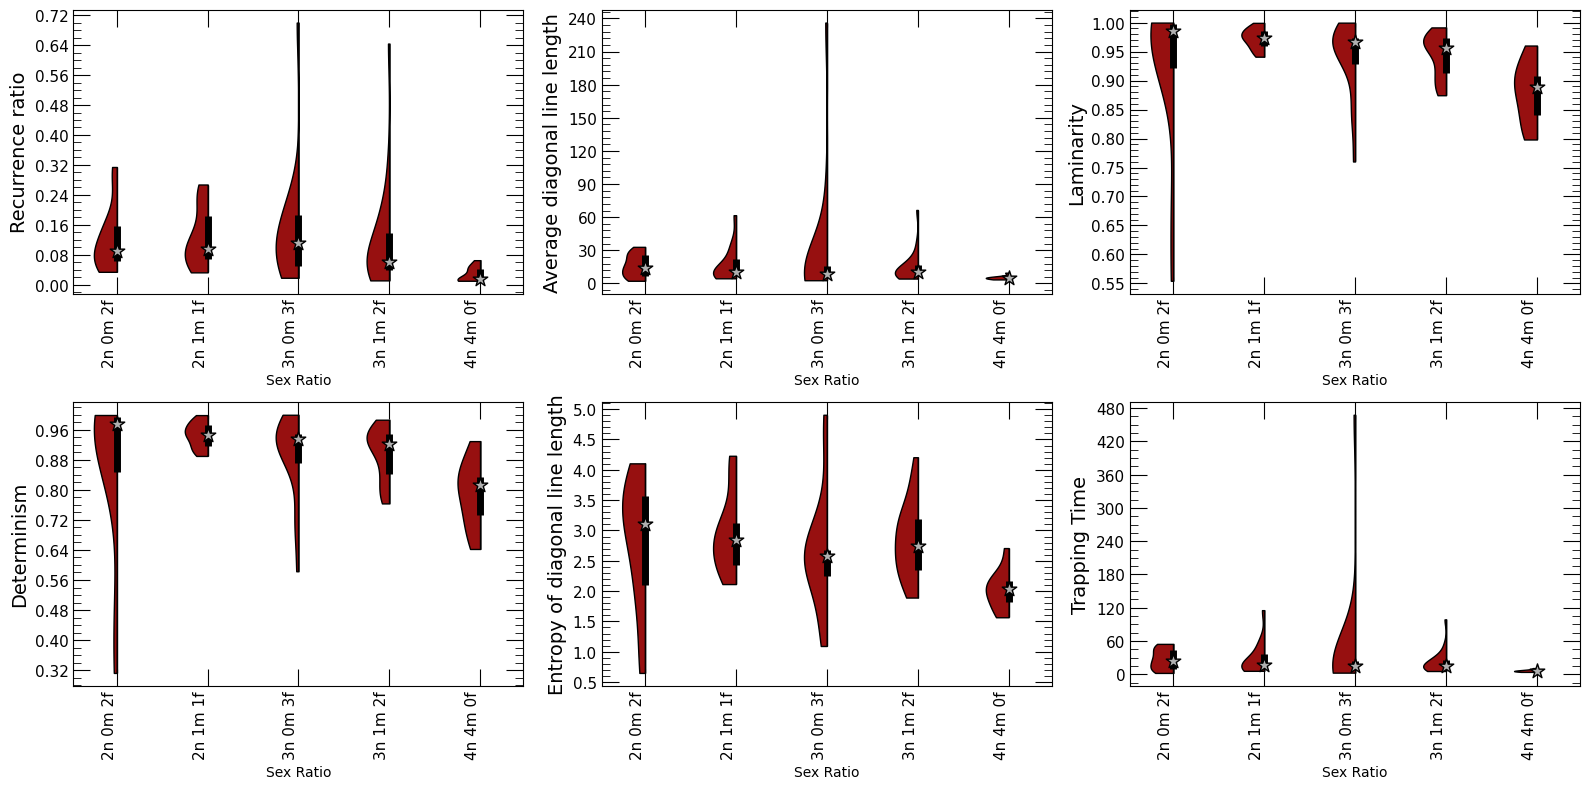

In [ ]:
fig_recurrence, axes_recurrence = ps.plot_crqa(
    df_metrics=df_metrics,
    width=16,
    height=8,
    n_y_breaks=10,
    save_figures=True,
    output_path=output_path,
    output_name="plot_gliding_recurrence_summary"
)
fig_recurrence

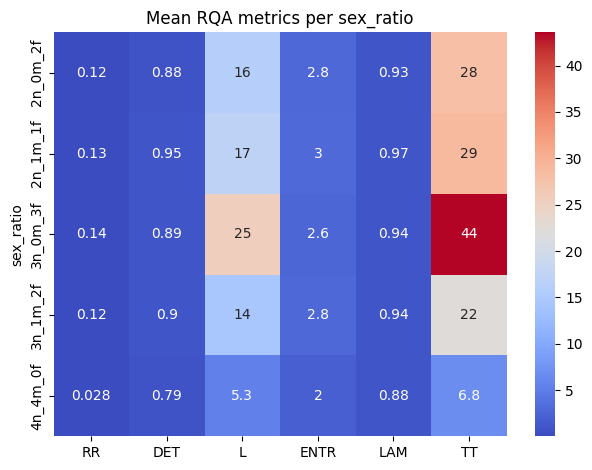

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
df_metrics["sex_ratio"] = df_metrics["video"].str[:8]

# Heat map with mean per variable
heat_data = df_metrics.groupby("sex_ratio")[["RR", "DET", "L", "ENTR", "LAM", "TT"]].mean()
sns.heatmap(heat_data, annot=True, cmap="coolwarm")
plt.title("Mean RQA metrics per sex_ratio")
plt.tight_layout()
plt.show()

Figure saved to ../output_files\plot_gliding_synchronization_summary.png


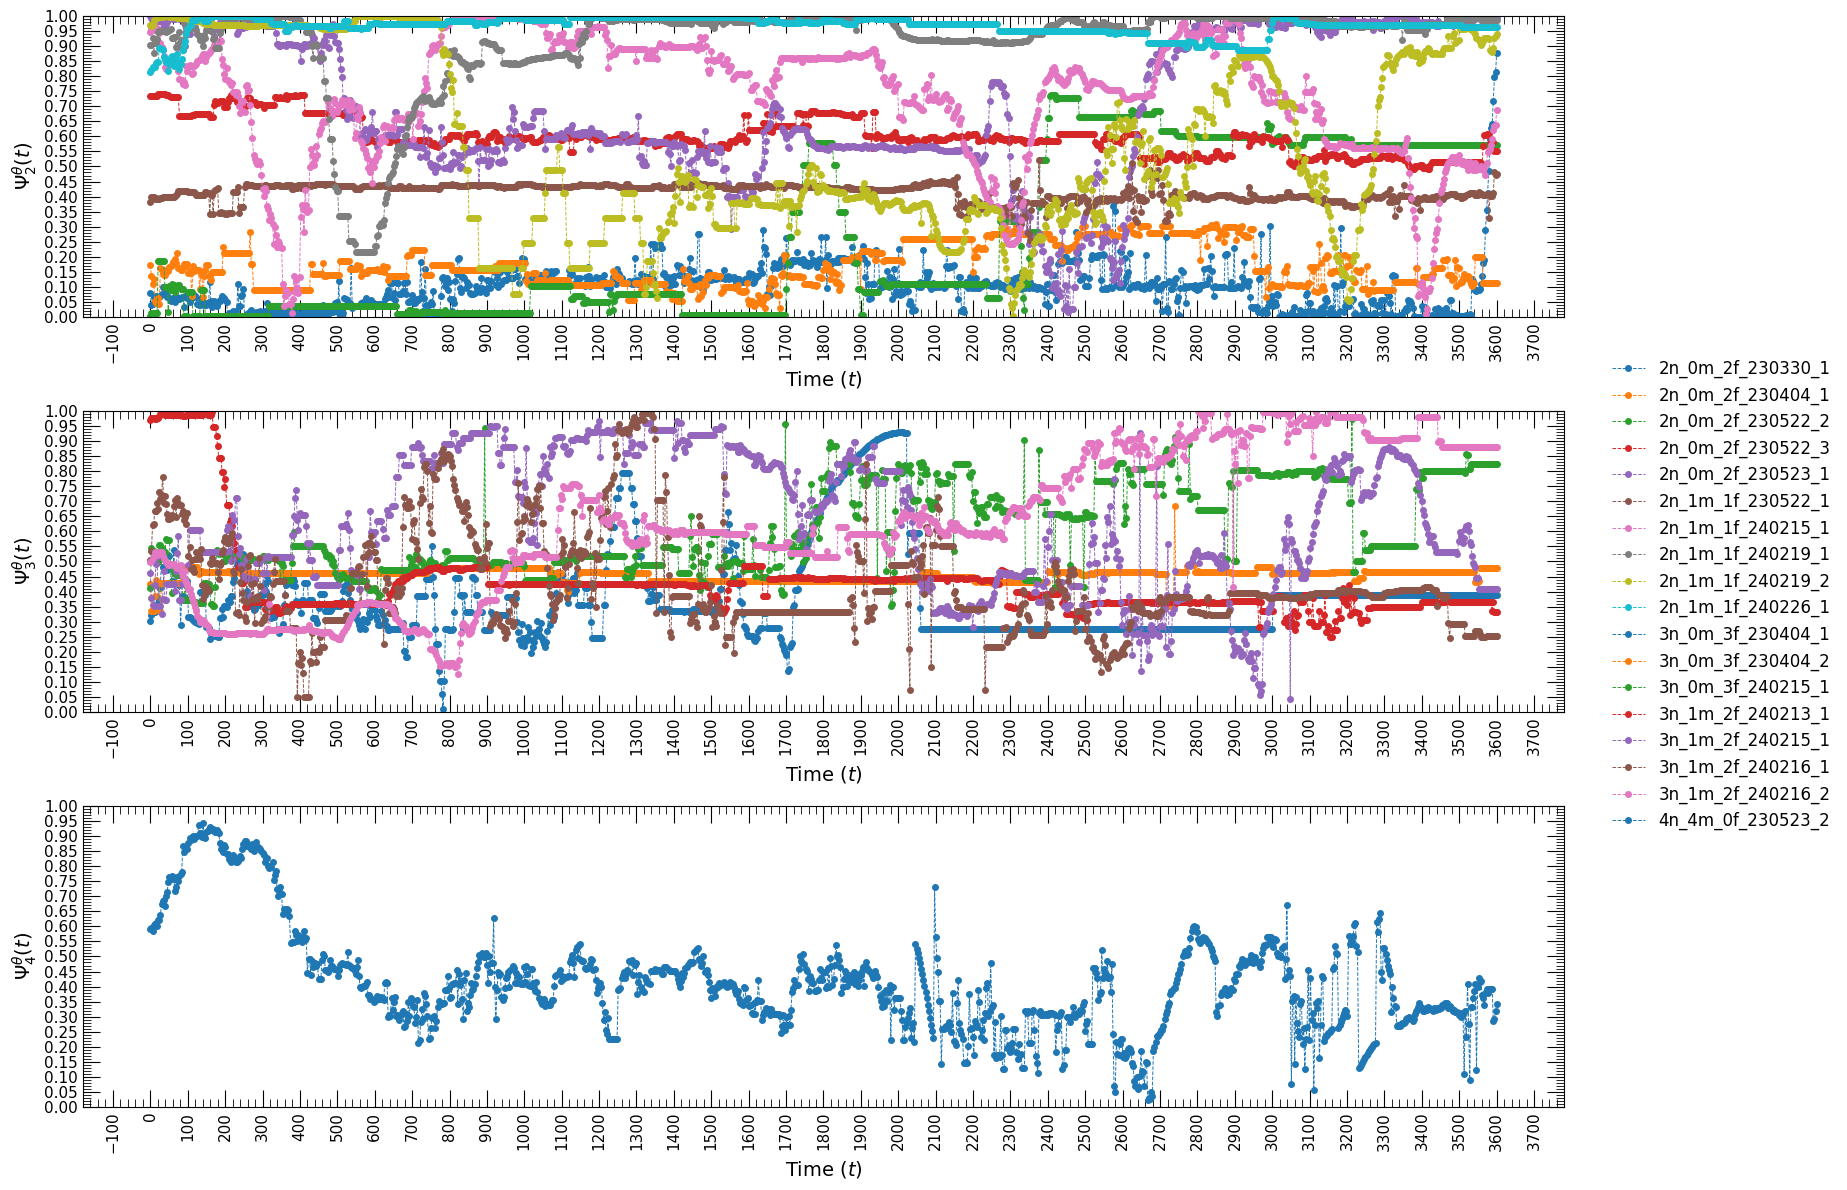

In [20]:
# Estimate Kuramoto order parameter
df_synchronization = []
for video in df_final["video"].unique():
    mask = df_final["video"] == video
    times, Rs = esa.estimate_kuramoto_order_parameter(df=df_final[mask])
    df_synchronization.append(pd.DataFrame({
        "video": [video]*len(times),
        "time": times,
        "order_parameter": Rs
    }))
df_synchronization = pd.concat(df_synchronization, ignore_index=True)

# Plot Kuramoto order parameter
fig_kuramoto, axes_kuramoto = ps.plot_kuramoto_order_parameter(
    df_synchronization=df_synchronization,
    width=16,
    height=12,
    n_x_breaks=40,
    n_y_breaks=20,
    fancy_legend=True,
    save_figures=True,
    output_path=output_path,
    output_name="plot_gliding_synchronization_summary"
)
fig_kuramoto

# How different is the behavior with different number of cockroaches?

- Aim: To quantify network properties (modularity, clustering, degree distribution).
- Data: Distances from the center of the box and orientation of the cockroaches respect to the vertical.

## Get Visibility Graph between individuals
The **Visibility Graph** ($VG$) is a method that transforms time series into a complex network, where data points in the series are mapped to nodes and edges are created based on visibility criteria.

### **Mathematical Formulation**
Given a time series $X = \{ x_1, x_2, ..., x_N \}$, two data points $(x_i, t_i)$ and $(x_j, t_j)$ are connected if any intermediate point $(x_k, t_k)$ satisfies:

\begin{equation}
    x_k < x_i + (x_j - x_i) \frac{t_k - t_i}{t_j - t_i}, \quad \forall k \in (i,j)
\end{equation}

In [21]:
window_sizes = [
    [30], [36], [45], [48], [60], [72], [75], [90],
    [120], [144], [150], [180], [225], [240],
    [300], [360], [450], [600],
    [720], [900], [1200], [1800], [t_threshold]
]
df_network_all, df_network_nodes = [], []
for video in df_final["video"].unique():
    df = df_final[df_final["video"] == video]
    df_all, df_nodes = ecna.estimate_multiple_vg(
        df=df,
        window_sizes=window_sizes,
        log_path=log_path,
        log_filename="log_network",
        verbose=1,
        tqdm_bar=True
    )
    df_network_all.append(df_all)
    df_network_nodes.append(df_nodes)

df_network_all = pd.concat(df_network_all, ignore_index=True)
df_network_all.to_csv(output_path + "/df_network.csv", index=False)

df_network_nodes = pd.concat(df_network_nodes, ignore_index=True)
df_network_nodes.to_csv(output_path + "/df_network_nodes.csv", index=False)

100%|███████████████████████| 23/23 [05:13<00:00, 13.63s/it]


In [22]:
for video in df_network_all["video"].unique():
    fig_complexity, ax_complexity = pcna.plot_gliding_complex_network(
        df_network_all=df_network_all[df_network_all["video"] == video],
        width=18,
        height=8,
        n_x_breaks=20,
        n_y_breaks=20,
        fancy_legend=True,
        save_figure=True,
        output_path=output_path,
        output_name="plot_gliding_network_" + video
    )

Figure saved to ../output_files\plot_gliding_network_2n_0m_2f_230330_1.png
Figure saved to ../output_files\plot_gliding_network_2n_0m_2f_230404_1.png
Figure saved to ../output_files\plot_gliding_network_2n_0m_2f_230522_2.png
Figure saved to ../output_files\plot_gliding_network_2n_0m_2f_230522_3.png
Figure saved to ../output_files\plot_gliding_network_2n_0m_2f_230523_1.png
Figure saved to ../output_files\plot_gliding_network_2n_1m_1f_230522_1.png
Figure saved to ../output_files\plot_gliding_network_2n_1m_1f_240215_1.png
Figure saved to ../output_files\plot_gliding_network_2n_1m_1f_240219_1.png
Figure saved to ../output_files\plot_gliding_network_2n_1m_1f_240219_2.png
Figure saved to ../output_files\plot_gliding_network_2n_1m_1f_240226_1.png
Figure saved to ../output_files\plot_gliding_network_3n_0m_3f_230404_1.png
Figure saved to ../output_files\plot_gliding_network_3n_0m_3f_230404_2.png
Figure saved to ../output_files\plot_gliding_network_3n_0m_3f_240215_1.png
Figure saved to ../output

In [23]:
df_cn_summary, fig_cn_1, fig_cn_2, ax_cn_1, ax_cn_2 = pcna.plot_complex_network_summary(
    df_network_all=df_network_all,
    width=24,
    height=12,
    n_x_breaks=20,
    n_y_breaks=20,
    fancy_legend=True,
    save_figures=True,
    output_path=output_path,
    output_name="plot_gliding_complex_network_summary"
)

Figure saved to ../output_files\plot_gliding_complex_network_summary_video.png and ../output_files\plot_gliding_complex_network_summary_sexratio.png


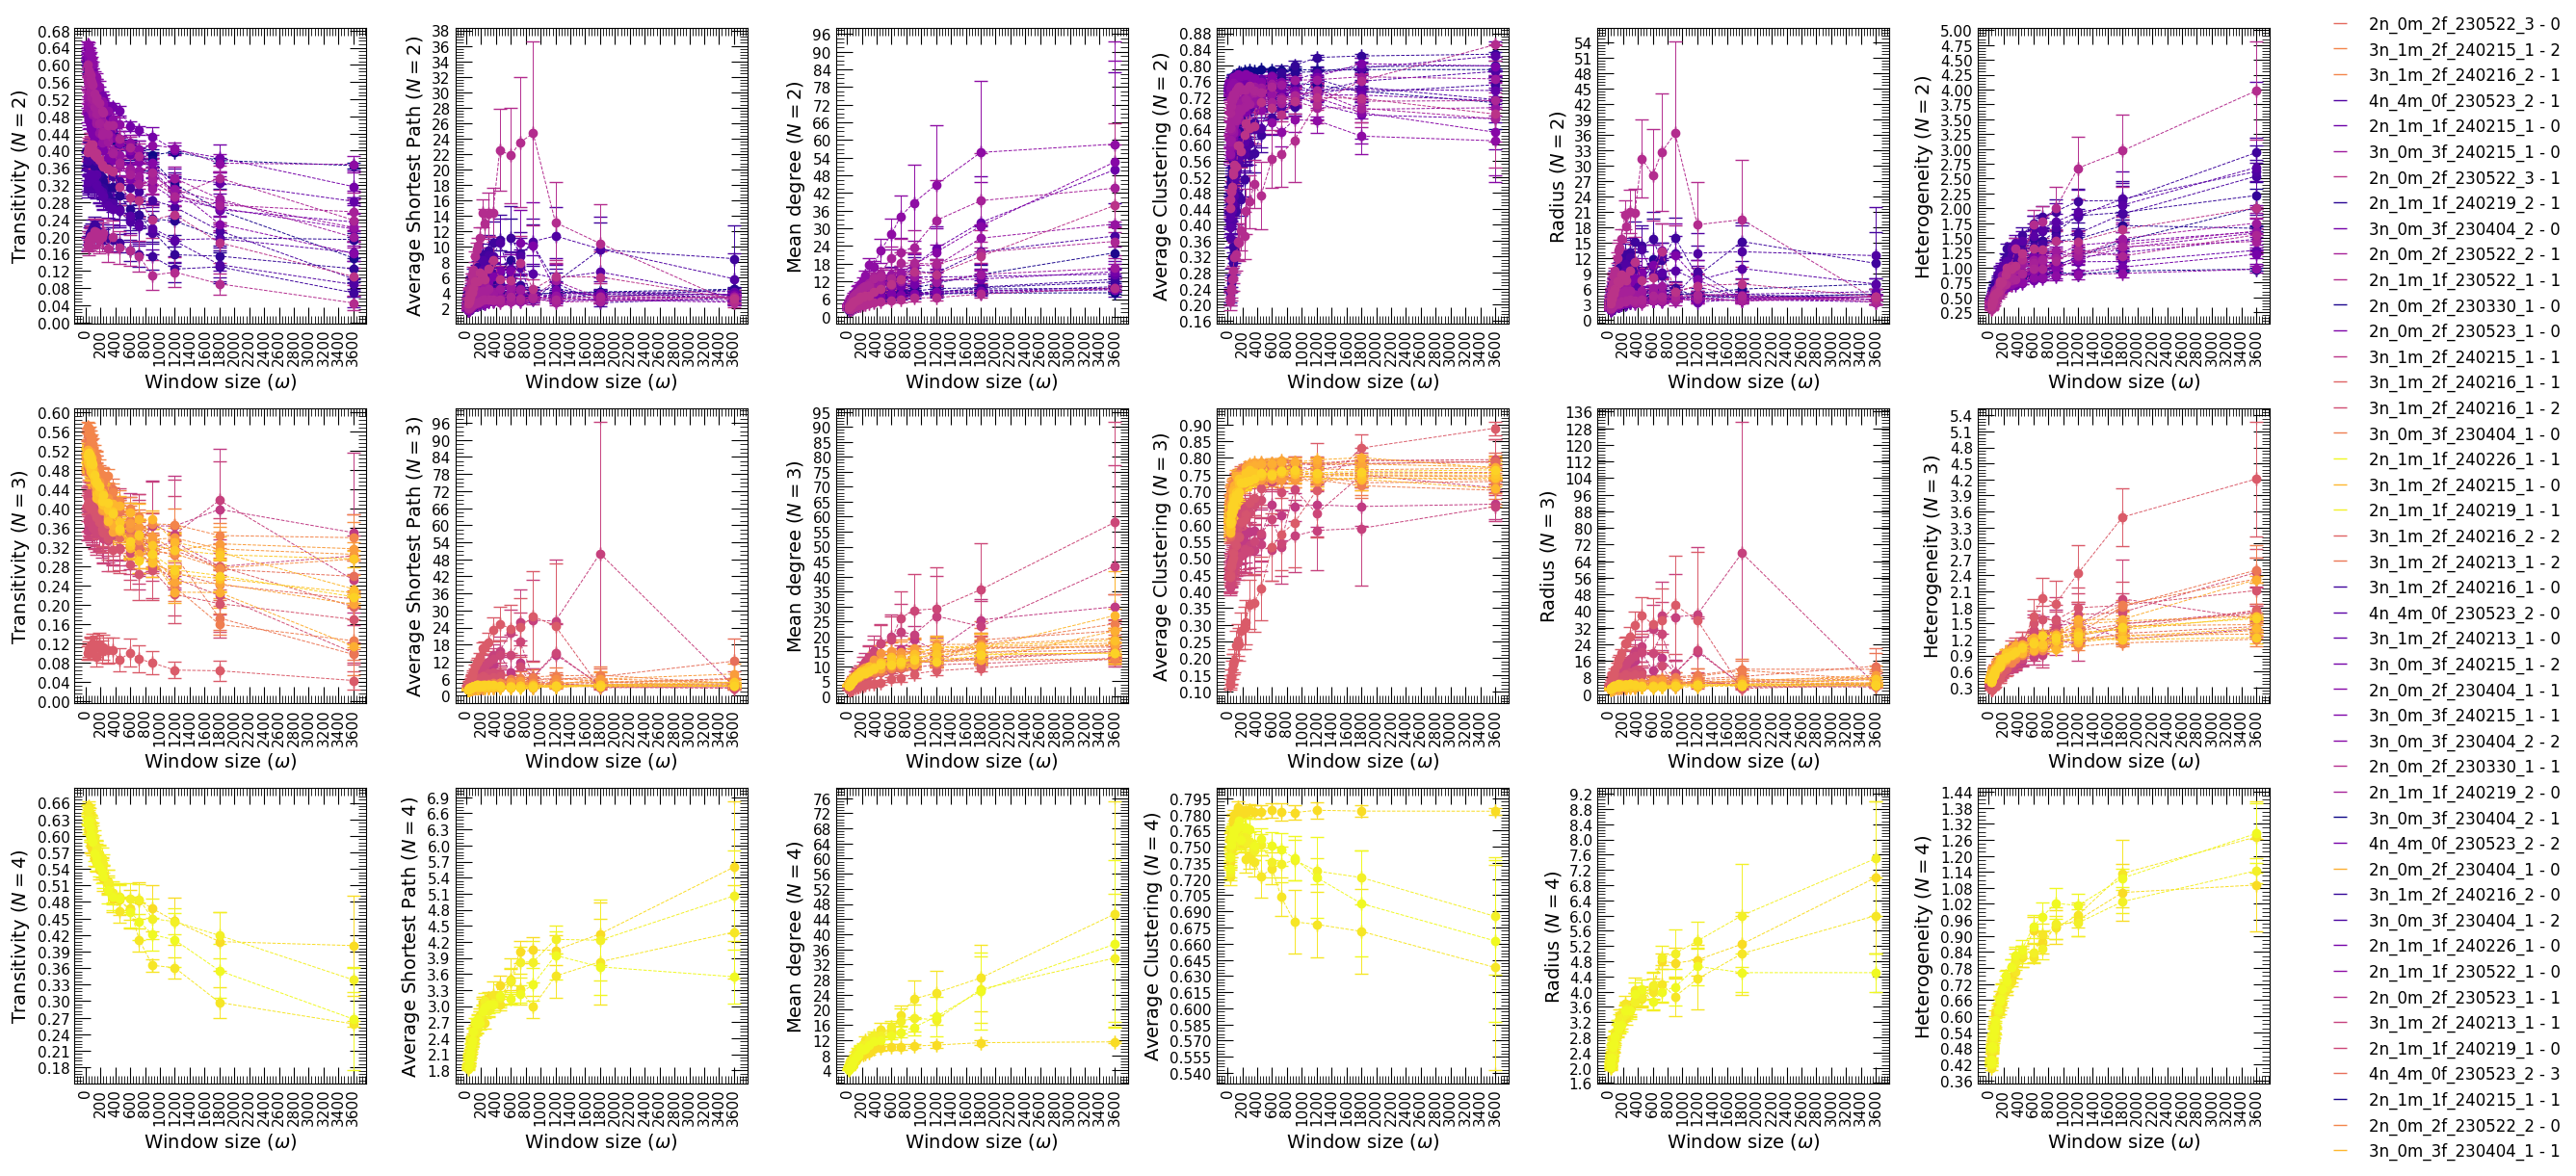

In [24]:
fig_cn_1

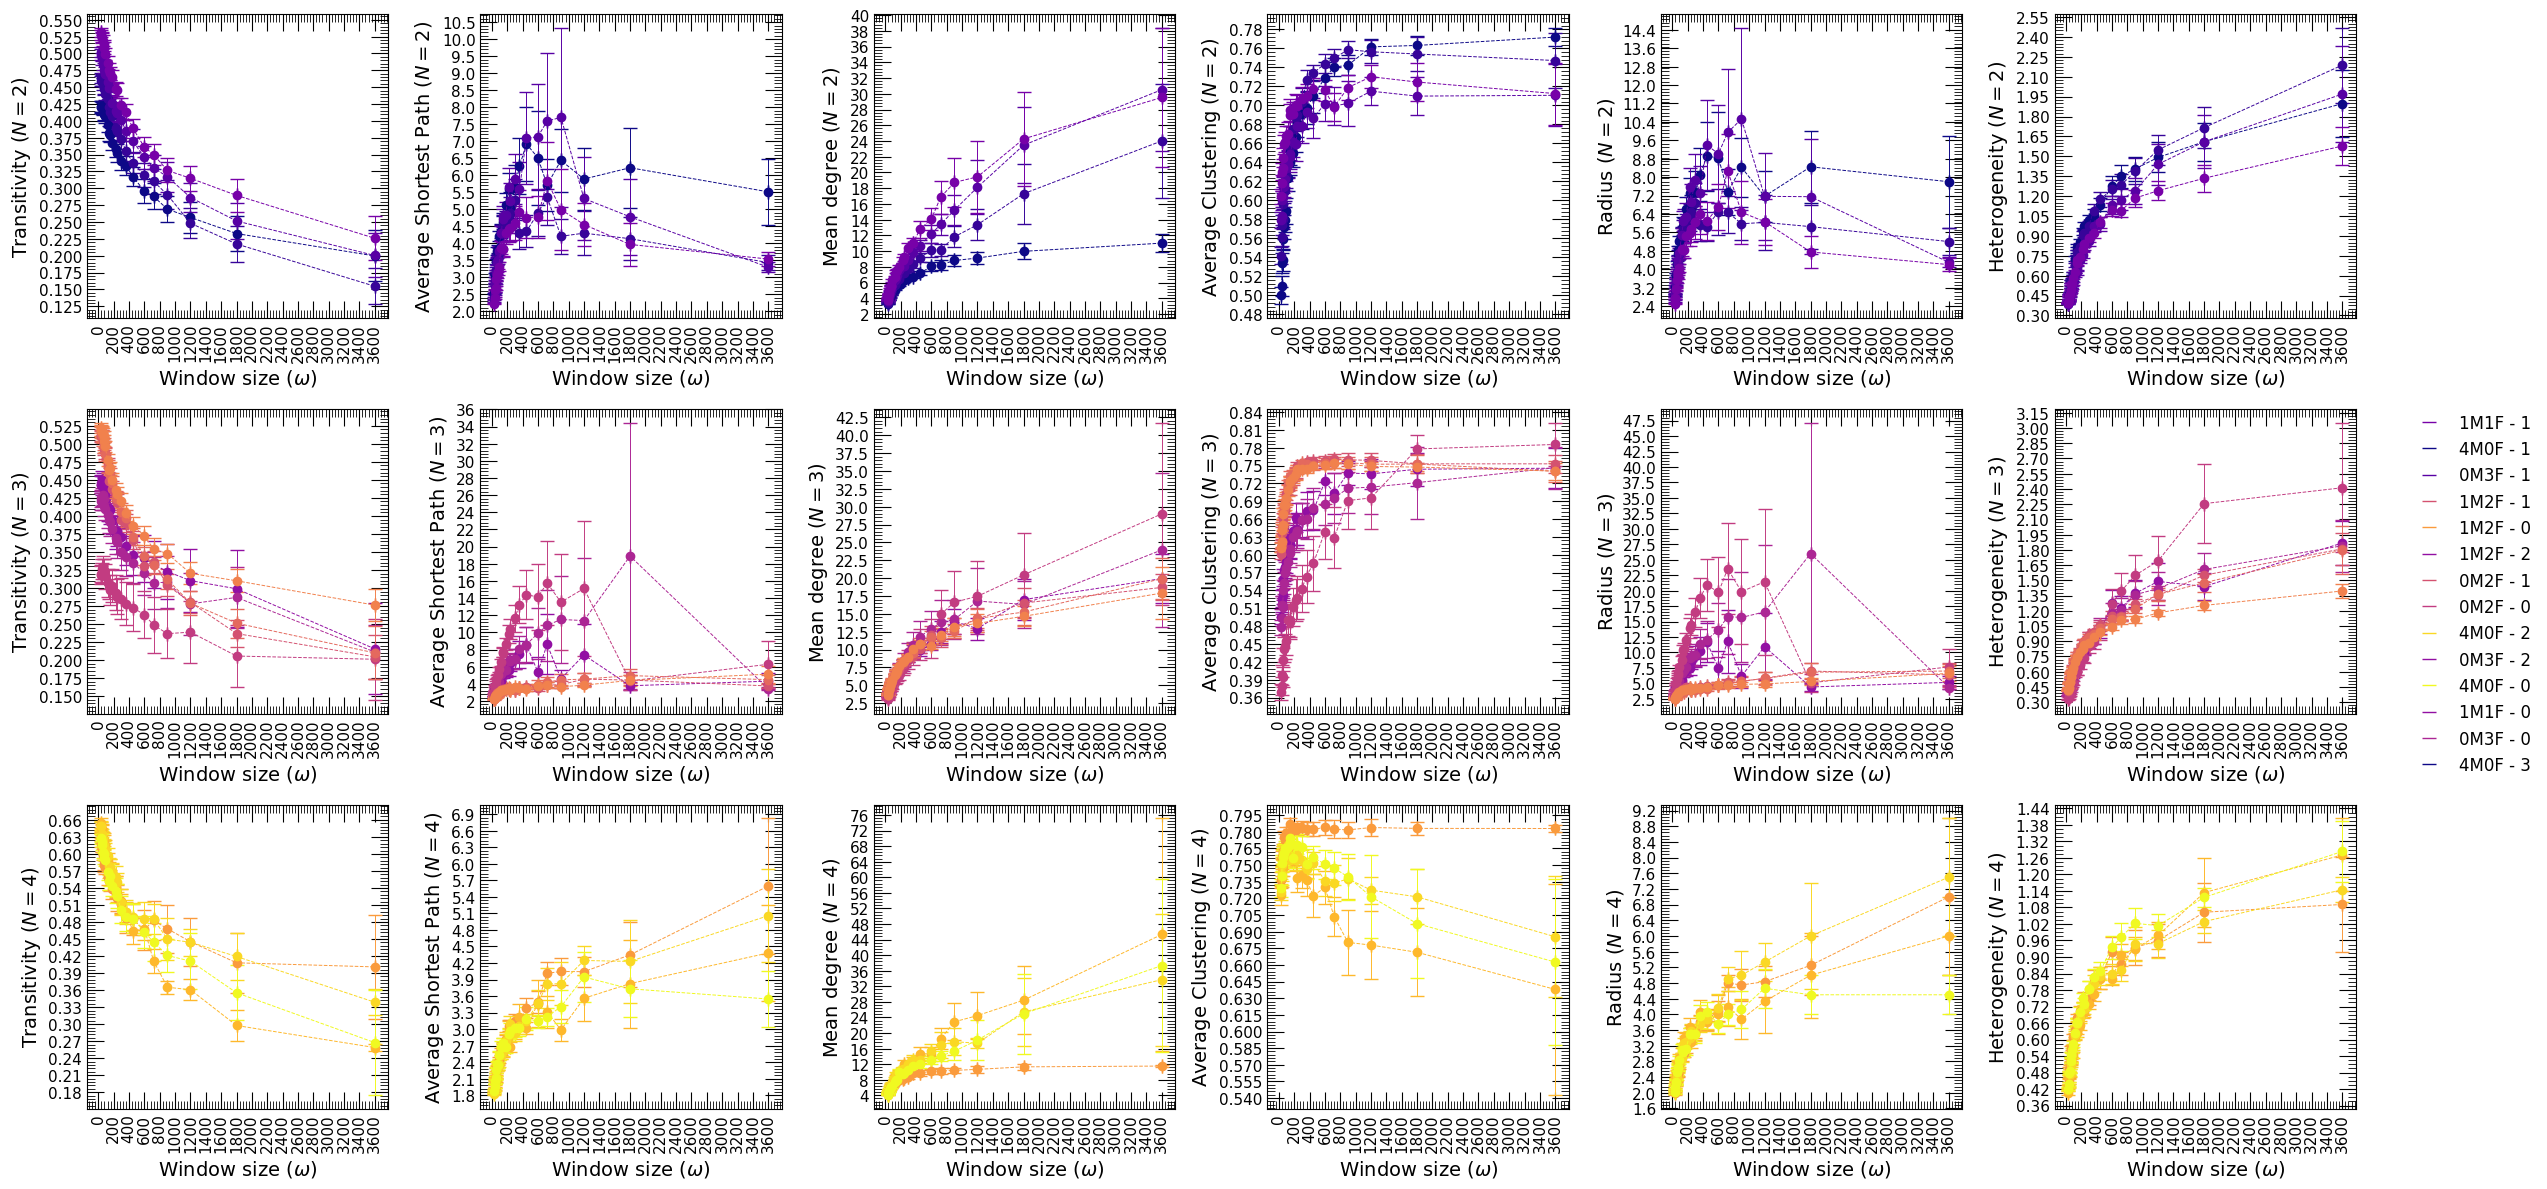

In [25]:
fig_cn_2